## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="darkgrid")

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from pprint import pprint

from wordcloud import WordCloud
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, classification_report, mean_squared_error, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition

from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter

## 1. Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json',)# Write the path to your data file and load it 
  
# returns JSON object as a dictionary 
data = json.load(f)
df = pd.json_normalize(data)

## 2. Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
# Check the number of entries in each column of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
# Get the shape of the dataframe
df.shape

(78313, 22)

In [6]:
# See the metrics for any numerical columns in the dataframe
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [7]:
# Print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
# Assign new column names
df.columns = df.columns.str.replace("_source.", "",regex=False)
df.columns = df.columns.str.replace("^_", "", regex=True)
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [9]:
# Check the data in the 'complaint_what_happened' field
df["complaint_what_happened"]

0                                                         
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                         
4                                                         
                               ...                        
78308                                                     
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [10]:
# Get the metrics on 'complaint_what_happened'
df["complaint_what_happened"].describe()

count     78313
unique    20931
top            
freq      57241
Name: complaint_what_happened, dtype: object

In [11]:
# Show the complaints from most frequent to least frequent
df["complaint_what_happened"].value_counts()

In [12]:
# Get the number of non-empty complaints 
df[df["complaint_what_happened"]!=""].shape

(21072, 22)

In [13]:
# Get the number of empty complaints 
df[df["complaint_what_happened"]==""].shape

(57241, 22)

In [14]:
# Get the number of null complaints 
df["complaint_what_happened"].isna().sum()

0

In [15]:
# Assign nan in place of blanks in the complaints column
df = df.replace(r'^\s*$', np.nan, regex=True)

In [16]:
# Get the number of null complaints after making empty complaints as null complaints
df["complaint_what_happened"].isna().sum()

57241

In [17]:
# Check the number of empty complaints 
df[df["complaint_what_happened"]==""].shape

(0, 22)

In [18]:
# Show the complaints from most frequent to least frequent
df["complaint_what_happened"].value_counts()

Chase has violated 15 USC 1692 by continuing collection activity after a cease and desist and 15 USC 1681 by failing to report complete and accurate information to credit reporting bureaus.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [19]:
# Remove all rows where complaints column is nan
df.dropna(subset = ['complaint_what_happened'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [20]:
# Get the shape of dataframe after removing nan columns
df.shape

(21072, 22)

In [21]:
# Sample records in the dataframe
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## 3. Prepare the text for topic modeling ( Text preprocessing )

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [22]:
# Write your function here to clean the text and remove all the unnecessary elements.

def replace_num_punc_sqre_brct_and_convert_low_case(strng) :
   
    # To replace text in square brackets
    strng=re.sub("\[.*?\]","[]",strng)
    
    # To replace punctuation marks
    strng = re.sub(r'[^\w\s]', '', strng)
    
    # To replace text containing numbers. 
    strng = re.sub(r'\w*\d\w*', '', strng)
    
    # To replace multiple spaces with single space.
    strng = re.sub("  ", " ", strng)
    
    # To return text in lower case
    return strng.lower()

In [23]:
# Check the above function 'replace_num_punc_sqre_brct_and_convert_low_case' on a sample text
print(replace_num_punc_sqre_brct_and_convert_low_case("Kalpana is shout'ing & unnecessarily at 1her a her2 a he3r 222 kids. [Abhi and Sammy]"))


kalpana is shouting unnecessarily at a a  kids 


In [24]:
# Check the complaints column in the dataframe
df['complaint_what_happened']

0        Good morning my name is XXXX XXXX and I apprec...
1        I upgraded my XXXX XXXX card in XX/XX/2018 and...
2        Chase Card was reported on XX/XX/2019. However...
3        On XX/XX/2018, while trying to book a XXXX  XX...
4        my grand son give me check for {$1600.00} i de...
                               ...                        
21067    After being a Chase Card customer for well ove...
21068    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
21069    I am not familiar with XXXX pay and did not un...
21070    I have had flawless credit for 30 yrs. I've ha...
21071    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 21072, dtype: object

In [25]:
# Apply the function 'replace_num_punc_sqre_brct_and_convert_low_case' on complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].apply(replace_num_punc_sqre_brct_and_convert_low_case)
df['complaint_what_happened']

0        good morning my name is xxxx xxxx and i apprec...
1        i upgraded my xxxx xxxx card in and was told b...
2        chase card was reported on however fraudulent ...
3        on while trying to book a xxxx xxxx ticket i c...
4        my grand son give me check for i deposit it in...
                               ...                        
21067    after being a chase card customer for well ove...
21068    on wednesday xxxxxxxx i called chas my xxxx xx...
21069    i am not familiar with xxxx pay and did not un...
21070    i have had flawless credit for yrs ive had cha...
21071    roughly years ago i closed out my accounts wit...
Name: complaint_what_happened, Length: 21072, dtype: object

In [26]:
# Write your function to Lemmatize the texts

def lemmatizer(text):        
    sentence = [word.lemma_ for word in nlp(text) if not word in nlp.Defaults.stop_words]
    return " ".join(sentence)

In [27]:
# Check the above function to lemmatize on a sample text
lemmatizer("Apples and oranges are similar. Boots and hippos aren't.")

"apple and orange be similar . boot and hippo be n't ."

In [28]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_what_happened']].copy()
df_clean.rename(columns={'complaint_what_happened': 'complaints'}, inplace=True)
df_clean['lemmatized_complaints'] = df_clean.complaints.apply(lemmatizer)

In [29]:
df_clean

,complaints,lemmatized_complaints
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...
2,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
3,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...
...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
21070,i have had flawless credit for yrs ive had cha...,I have have flawless credit for yr I ve have c...


In [30]:
# Change the dataframe column widthe so that it can display a maximum of 1000 chars in each cell
pd.options.display.max_colwidth = 1000
df_clean

,complaints,lemmatized_complaints
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the appli...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I ask for more information about the xxxx offer and she explain that even if I have be approve the credit offer only gets apply after the first account statement and could not be use to purchase the ticket I then explicitly tell she I be glad I got deny and I be absolutely no long interested in the account I ask that the application be withdraw and the representative oblige this all happen no later than after put in the applic

In [31]:
# Write your function to extract the POS tags - NN
def get_noun_tags(text): 
    noun_words = []
    doc = nlp(text)
    for word in doc:
        if word.pos_=="NOUN" : # if word.tag_ in ('NN', 'NNS', 'NNP','NNPS' ) : word.pos_=="NOUN" :
            noun_words.append(word.text)
    return " ".join(noun_words)


In [32]:
# Check the above function to extract nouns on a sample text
get_noun_tags("Apples and oranges are similar. Boots and hippos aren't. He is an idiot")

'Apples oranges Boots hippos idiot'

In [33]:
# Check the above function to lemmatize on a lemmatized complaints and store them in a seperate column in df_clean dataframe
df_clean['nouns_in_lemmatized_complaints'] = df_clean["lemmatized_complaints"].apply(get_noun_tags)


In [34]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean


,complaints,lemmatized_complaints,nouns_in_lemmatized_complaints
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name xxxx stop debt verification statement bank debt mail month debt right information consumer chase account xxxx xxxx xxxx xxxx advance help
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx xxxx card agent anniversary date agent information order account anniversary date consent xxxx recording agent
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase report application identity consent service credit identity applicant
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the appli...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I ask for more information about the xxxx offer and she 

#### 4. Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘


#### 4.1 EDA on Chars of Original Complaints column in dataframe

In [35]:
num_of_chars_in_complaint = [len(d) for d in df_clean["complaints"]]

print("Total number of complaints are", len(num_of_chars_in_complaint))
print("The minimum number of characters in a complaint are", min(num_of_chars_in_complaint))
print("The maximum number of characters in a complaint are", max(num_of_chars_in_complaint))

Total number of complaints are 21072
The minimum number of characters in a complaint are 0
The maximum number of characters in a complaint are 30610


Text(0.5, 1.0, 'Chars in complaints - Bar analysis')

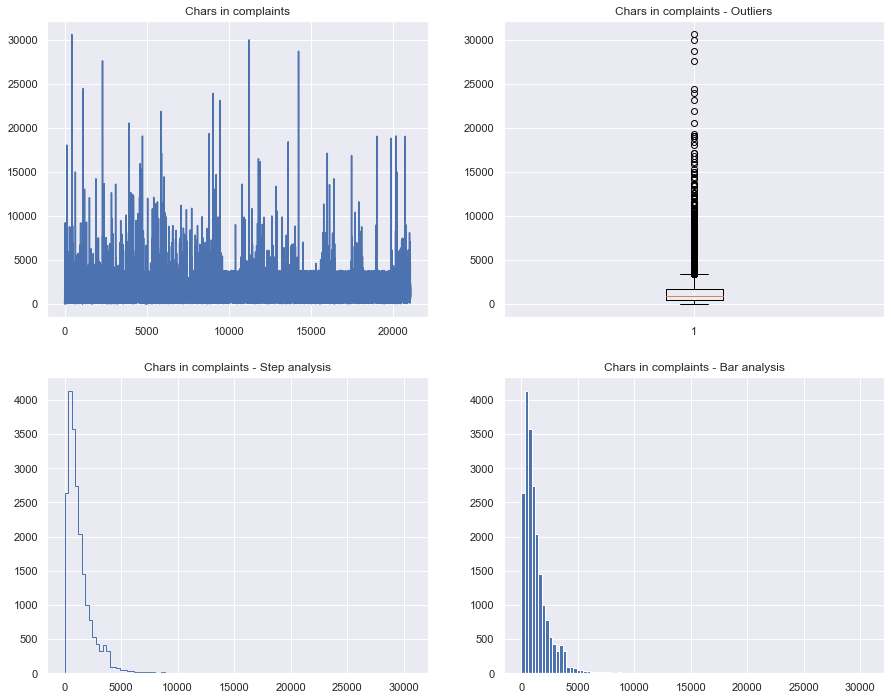

In [36]:
# Write your code here to visualise the data according to the 'Complaint' character length
fig = plt.figure(figsize=(15, 12))

plt.subplot(2,2,1)
plt.plot(num_of_chars_in_complaint)
plt.title("Chars in complaints")

plt.subplot(2,2,2)
plt.boxplot(num_of_chars_in_complaint)
plt.title("Chars in complaints - Outliers")

plt.subplot(2,2,3)
plt.hist(num_of_chars_in_complaint, bins = 100,  histtype = 'step')
plt.title("Chars in complaints - Step analysis")

plt.subplot(2,2,4)
plt.hist(num_of_chars_in_complaint, bins = 100)
plt.title("Chars in complaints - Bar analysis")

#### 4.2 EDA on Words of Original Complaints column in dataframe

In [37]:
num_of_words_in_complaint = [len(d.split()) for d in df_clean["complaints"]]

print("Total number of complaints are", len(num_of_words_in_complaint))
print("The minimum number of words in a complaint are", min(num_of_words_in_complaint))
print("The maximum number of words in a complaint are", max(num_of_words_in_complaint))

Total number of complaints are 21072
The minimum number of words in a complaint are 0
The maximum number of words in a complaint are 5257


Text(0.5, 1.0, 'Words in complaints - Bar analysis')

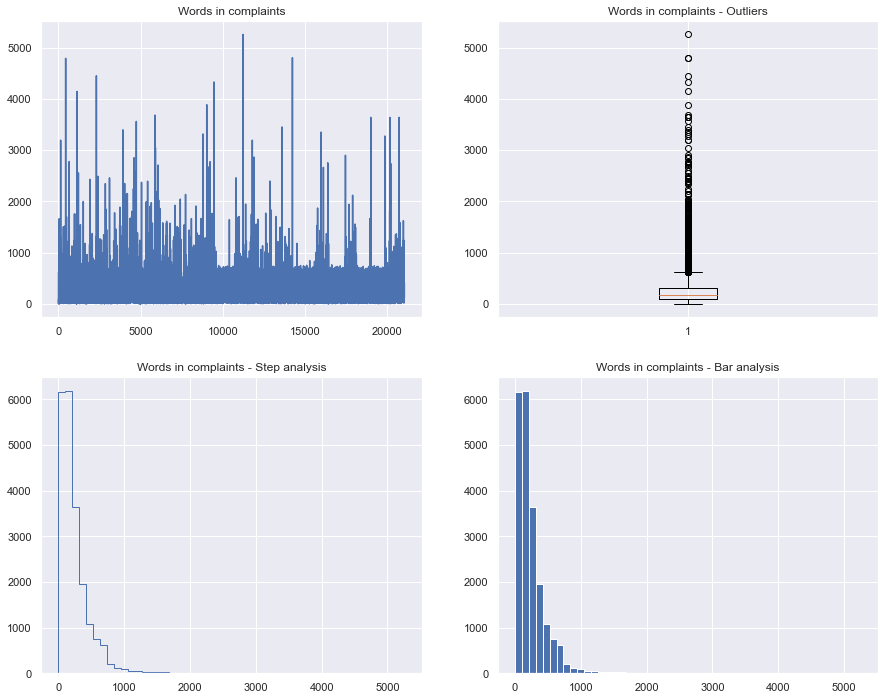

In [38]:
# Write your code here to visualise the data according to the 'Complaint' character length
fig = plt.figure(figsize=(15, 12))

plt.subplot(2,2,1)
plt.plot(num_of_words_in_complaint)
plt.title("Words in complaints")

plt.subplot(2,2,2)
plt.boxplot(num_of_words_in_complaint)
plt.title("Words in complaints - Outliers")

plt.subplot(2,2,3)
plt.hist(num_of_words_in_complaint, bins = 50,  histtype = 'step')
plt.title("Words in complaints - Step analysis")

plt.subplot(2,2,4)
plt.hist(num_of_words_in_complaint, bins = 50)
plt.title("Words in complaints - Bar analysis")

### 4.3  EDA on Chars of the column 'nouns_in_lemmatized_complaints'

In [39]:
num_of_chars_in_complaint = [len(d) for d in df_clean["nouns_in_lemmatized_complaints"]]

print("Total number of 'nouns_in_lemmatized_complaints' are", len(num_of_chars_in_complaint))
print("The minimum number of characters in a 'nouns_in_lemmatized_complaints' are", min(num_of_chars_in_complaint))
print("The maximum number of characters in a 'nouns_in_lemmatized_complaints' are", max(num_of_chars_in_complaint))

Total number of 'nouns_in_lemmatized_complaints' are 21072
The minimum number of characters in a 'nouns_in_lemmatized_complaints' are 0
The maximum number of characters in a 'nouns_in_lemmatized_complaints' are 13672


Text(0.5, 1.0, "Chars in 'nouns_in_lemmatized_complaints' - Bar analysis")

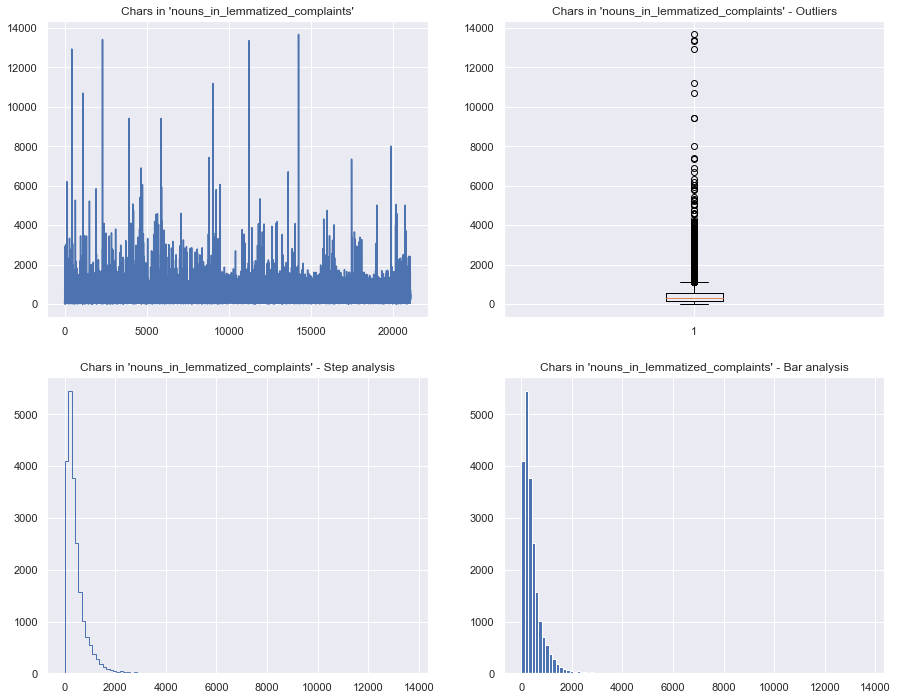

In [40]:
# Write your code here to visualise the data according to the 'Complaint' character length
fig = plt.figure(figsize=(15, 12))

plt.subplot(2,2,1)
plt.plot(num_of_chars_in_complaint)
plt.title("Chars in 'nouns_in_lemmatized_complaints'")

plt.subplot(2,2,2)
plt.boxplot(num_of_chars_in_complaint)
plt.title("Chars in 'nouns_in_lemmatized_complaints' - Outliers")

plt.subplot(2,2,3)
plt.hist(num_of_chars_in_complaint, bins = 100,  histtype = 'step')
plt.title("Chars in 'nouns_in_lemmatized_complaints' - Step analysis")

plt.subplot(2,2,4)
plt.hist(num_of_chars_in_complaint, bins = 100)
plt.title("Chars in 'nouns_in_lemmatized_complaints' - Bar analysis")

### 4.4  EDA on Words of the column 'nouns_in_lemmatized_complaints'

In [41]:
num_of_words_in_complaint = [len(d.split()) for d in df_clean["nouns_in_lemmatized_complaints"]]

print("Total number of complaints are", len(num_of_words_in_complaint))
print("The minimum number of words in a 'nouns_in_lemmatized_complaints' are", min(num_of_words_in_complaint))
print("The maximum number of words in a 'nouns_in_lemmatized_complaints' are", max(num_of_words_in_complaint))

Total number of complaints are 21072
The minimum number of words in a 'nouns_in_lemmatized_complaints' are 0
The maximum number of words in a 'nouns_in_lemmatized_complaints' are 2004


Text(0.5, 1.0, "Words in 'nouns_in_lemmatized_complaints' - Bar analysis")

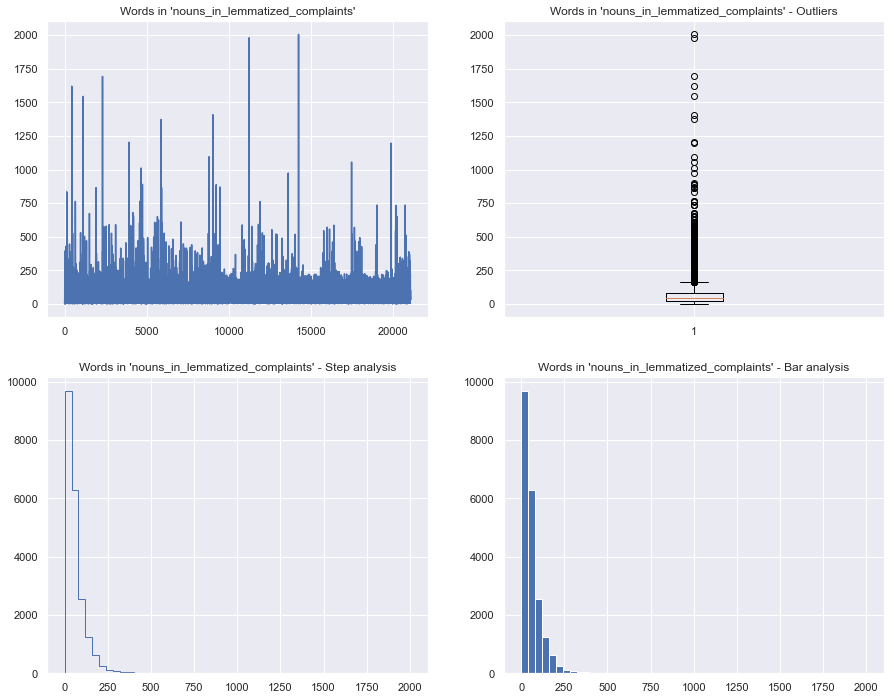

In [42]:
# Write your code here to visualise the data according to the 'Complaint' character length
fig = plt.figure(figsize=(15, 12))

plt.subplot(2,2,1)
plt.plot(num_of_words_in_complaint)
plt.title("Words in 'nouns_in_lemmatized_complaints'")

plt.subplot(2,2,2)
plt.boxplot(num_of_words_in_complaint)
plt.title("Words in 'nouns_in_lemmatized_complaints' - Outliers")

plt.subplot(2,2,3)
plt.hist(num_of_words_in_complaint, bins = 50,  histtype = 'step')
plt.title("Words in 'nouns_in_lemmatized_complaints' - Step analysis")

plt.subplot(2,2,4)
plt.hist(num_of_words_in_complaint, bins = 50)
plt.title("Words in 'nouns_in_lemmatized_complaints' - Bar analysis")

### 4.5 Find the top 40 words by frequency among all the articles after processing the text.

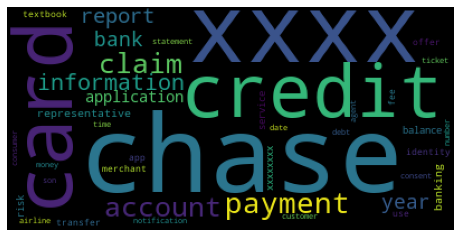

In [43]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(stopwords=nlp.Defaults.stop_words,max_words=40).generate(str(df_clean["nouns_in_lemmatized_complaints"]))

print(wordcloud)
fig = plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();


In [44]:
# Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['nouns_in_lemmatized_complaints'].str.replace('-PRON-', '')

#### Below comparison shows that there are no PRON in 'nouns_in_lemmatized_complaints' column and hence both Complaint_clean and nouns_in_lemmatized_complaints are same and equal

In [45]:
# Create a column where it stores True when Complaint_clean and nouns_in_lemmatized_complaints are same else False
comparison_column = np.where(df_clean["Complaint_clean"] == df_clean["nouns_in_lemmatized_complaints"], True, False)

# Check whether 'Complaint_clean' and 'nouns_in_lemmatized_complaints' columns are equal by checking whether there are any comparison columns with 'False' as value 
print(comparison_column[comparison_column == False])

[]


### 4.7 Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [46]:
# Function to get unigrams, bigrams, trigrams asnd so on
def get_top_n_grams(corpus, num_of_words=1, frequency=None):
    vec = CountVectorizer(ngram_range=(num_of_words, num_of_words), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:frequency]

In [47]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigrams = get_top_n_grams(df_clean['Complaint_clean'], 1, 30)

In [48]:
#Print the top 10 words in the unigram frequency
pd.DataFrame(unigrams, columns = ['unigram' , 'count']).iloc[:10,:]

,unigram,count
0,xxxx,144733
1,chase,55259
2,account,47369
3,credit,33429
4,card,29841
5,payment,21164
6,bank,20627
7,time,16025
8,xxxxxxxx,15453
9,charge,14545


In [49]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = get_top_n_grams(df_clean['Complaint_clean'], 2, 30)

In [50]:
#Print the top 10 words in the bigram frequency
pd.DataFrame(bigrams, columns = ['bigram' , 'count']).iloc[:10,:]

,bigram,count
0,xxxx xxxx,67256
1,credit card,12732
2,credit report,3964
3,xxxx chase,3828
4,account xxxx,3108
5,customer service,3082
6,chase credit,2964
7,account chase,2901
8,xxxx account,2839
9,chase bank,2657


In [51]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = get_top_n_grams(df_clean['Complaint_clean'], 3, 30)

In [52]:
#Print the top 10 words in the trigram frequency
pd.DataFrame(trigrams, columns = ['trigram' , 'count']).iloc[:10,:]

,trigram,count
0,xxxx xxxx xxxx,35444
1,chase credit card,1976
2,xxxx xxxx chase,1663
3,account xxxx xxxx,1254
4,xxxx xxxx account,1129
5,credit card account,1098
6,xxxxxxxx xxxx xxxx,1039
7,credit card company,987
8,xxxx credit card,985
9,chase xxxx xxxx,969


###  4.8 The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [53]:
# Replace 'xxxx' in Complaint_clean column
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [54]:
# All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,nouns_in_lemmatized_complaints,Complaint_clean
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name xxxx stop debt verification statement bank debt mail month debt right information consumer chase account xxxx xxxx xxxx xxxx advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx xxxx card agent anniversary date agent information order account anniversary date consent xxxx recording agent,card agent anniversary date agent information order account anniversary date consent recording agent
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase report application identity consent service credit identity applicant,chase report application identity consent service credit identity applicant
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the appli...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be mak

### 4.9 Word Cloud after replacing 'XXXX'

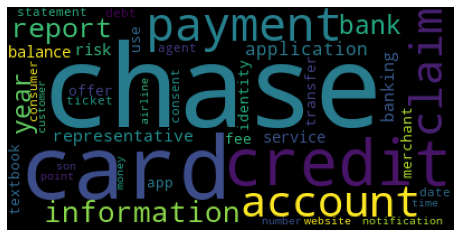

In [55]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(stopwords=nlp.Defaults.stop_words,max_words=40).generate(str(df_clean["Complaint_clean"]))

print(wordcloud)
fig = plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

## 5. Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [56]:
# Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

### 5.1 Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [57]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean["Complaint_clean"])

In [58]:
print(dtm)

  (0, 2952)	0.21535224088993848
  (0, 122)	0.2897004004080523
  (0, 41)	0.08931769772198792
  (0, 1012)	0.07768570459034183
  (0, 1365)	0.20017628437890933
  (0, 3214)	0.14301631200544374
  (0, 5408)	0.24435501843509483
  (0, 4007)	0.14316943059143117
  (0, 3713)	0.18991724854888933
  (0, 516)	0.11343014998380971
  (0, 5951)	0.1763601702820251
  (0, 6653)	0.2834181655292951
  (0, 1664)	0.6198229424645738
  (0, 5996)	0.32047176405413225
  (0, 4020)	0.26020557509079456
  (1, 5104)	0.254992445115857
  (1, 1338)	0.23123863493620686
  (1, 4298)	0.15816689068441203
  (1, 1622)	0.25455826046194735
  (1, 265)	0.6677879628070824
  (1, 164)	0.5665455450017342
  (1, 876)	0.08448034282931301
  (1, 41)	0.07035258221464619
  (1, 3214)	0.1126491961281437
  (2, 300)	0.5171706182947569
  :	:
  (21070, 2467)	0.127789657704086
  (21070, 5275)	0.14478318478740781
  (21070, 1528)	0.15305952402688353
  (21070, 876)	0.29325887663710143
  (21070, 1012)	0.2124120402280048
  (21071, 5541)	0.23587238238363298
  

In [59]:
# Dataframe showing feature names along with tfidf scores
pd.DataFrame(dtm.toarray(), columns = tfidf.get_feature_names())

,aa,aarp,ab,aba,abandonment,abatement,abbreviation,abd,abide,ability,...,yoga,youinv,youth,yr,yrs,zilch,zip,zipcode,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.148117,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# Show the feature names
tfidf.get_feature_names()

['aa',
 'aarp',
 'ab',
 'aba',
 'abandonment',
 'abatement',
 'abbreviation',
 'abd',
 'abide',
 'ability',
 'abovementione',
 'abovereference',
 'absence',
 'absent',
 'absolve',
 'absurdity',
 'abundance',
 'abuse',
 'abuser',
 'ac',
 'acc',
 'acccount',
 'acceleration',
 'accent',
 'accept',
 'acceptance',
 'access',
 'accessibility',
 'accessory',
 'accident',
 'accommodation',
 'accomodation',
 'accompany',
 'accomplice',
 'accont',
 'accord',
 'accordance',
 'according',
 'accou',
 'accouint',
 'accoun',
 'account',
 'accountability',
 'accountant',
 'accountbalance',
 'accountchase',
 'accountholder',
 'accounti',
 'accounting',
 'accountit',
 'accountlevel',
 'accountone',
 'accountplease',
 'accout',
 'accredit',
 'accrual',
 'accrue',
 'acct',
 'accumulate',
 'accumulation',
 'accunt',
 'accuracy',
 'accurateness',
 'accusation',
 'accuse',
 'ach',
 'acion',
 'acivity',
 'ack',
 'acknowledge',
 'acknowledgement',
 'acknowledgment',
 'acocunt',
 'acoount',
 'acount',
 'acquain

In [61]:
# Get the total number of features
len(tfidf.get_feature_names())

6925

## 6. Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [62]:
from sklearn.decomposition import NMF

### 6.1 Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

#### 6.1.1 Get Sample topics

In [63]:
# Function to create W & H dataframes and get the relevant topics with differing number of topics and words in each topic 
def get_topics(num_topics, num_words) :
    nmf_model = decomposition.NMF(n_components=num_topics, random_state=40)
    nmf_model.fit(dtm)
    W = nmf_model.fit_transform(dtm)  # Document-topic matrix
    H = nmf_model.components_       # Topic-term matrix
    words = np.array(tfidf.get_feature_names())
    topic_words = pd.DataFrame(np.zeros((num_topics, num_words)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(num_words)]).astype(str)
    for i in range(num_topics):
        ix = H[i].argsort()[::-1][:num_words]
        topic_words.iloc[i] = words[ix]
    return topic_words

In [64]:
# Group the data into 15 topics and show top 10 words in each topic
get_topics(15, 10)

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,account,checking,chase,reason,deposit,branch,fund,business,access,year
Topic 2,card,credit,chase,score,year,limit,company,point,application,purchase
Topic 3,payment,month,day,time,statement,chase,auto,date,pay,error
Topic 4,report,credit,debt,reporting,bureaus,company,information,score,identity,theft
Topic 5,chase,letter,information,dispute,number,email,phone,service,time,customer
Topic 6,charge,dispute,merchant,company,fraud,purchase,statement,month,billing,visa
Topic 7,check,deposit,fund,cash,day,hold,branch,chase,business,cashier
Topic 8,fee,overdraft,year,time,customer,fund,dollar,service,day,month
Topic 9,money,day,transfer,deposit,person,chase,dollar,atm,company,wire
Topic 10,bank,fund,branch,customer,wire,manager,complaint,number,transfer,person


#### Possible topic names for the above 15 topics

* Topic-01 is bank accounts
* Topic-02 is Credit Card
* Topic-03 is Mortgage / Home loan
* Topic-04 is Dispute
* Topic-05 is Credit Card
* Topic-06 is Credit check
* Topic-07 is bank accounts
* Topic-08 is bank accounts
* Topic-09 is fraud
* Topic-10 is complaints
* Topic-11 is credit enquiry
* Topic-12 is balance transfer
* Topic-13 is Disputes
* Topic-14 is bank accounts
* Topic-15 is loans

In [65]:
# Group the data into 10 topics and show top 10 words in each topic
get_topics(10, 10)

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,account,checking,chase,reason,deposit,balance,branch,business,year,fund
Topic 2,card,credit,chase,balance,score,limit,year,purchase,company,month
Topic 3,payment,month,balance,statement,day,time,credit,chase,auto,date
Topic 4,report,inquiry,credit,company,reporting,information,bureaus,identity,score,debt
Topic 5,chase,letter,information,dispute,number,email,phone,time,service,state
Topic 6,charge,dispute,merchant,fraud,transaction,purchase,company,statement,card,month
Topic 7,check,deposit,fund,bank,cash,day,branch,hold,chase,business
Topic 8,fee,overdraft,balance,transfer,year,customer,time,chase,month,fund
Topic 9,money,bank,transaction,claim,fund,debit,fraud,day,transfer,atm
Topic 10,loan,mortgage,home,modification,year,property,rate,foreclosure,chase,house


#### Possible topic names for the above 10 topics

* Topic-01 is Bank account services
* Topic-02 is Credit card / Prepaid card
* Topic-03 is Mortgages / Loans
* Topic-04 is Theft/Dispute reporting
* Topic-05 is Others - Statement
* Topic-06 is Mortgages / Loans
* Topic-07 is Others - Check
* Topic-08 is Others - Overdraft / Balnce transfer
* Topic-09 is Disputes
* Topic-10 is Other - ATM

In [66]:
# Group the data into 7 topics and show top 10 words in each topic
get_topics(7, 10)

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,account,chase,bank,money,checking,number,branch,fund,transfer,information
Topic 2,card,credit,chase,balance,score,limit,year,point,purchase,offer
Topic 3,payment,balance,fee,month,statement,day,time,credit,auto,date
Topic 4,report,inquiry,credit,company,reporting,information,debt,bureaus,identity,score
Topic 5,loan,mortgage,chase,home,modification,property,year,letter,rate,time
Topic 6,charge,dispute,transaction,fee,chase,merchant,claim,fraud,purchase,service
Topic 7,check,bank,fund,deposit,money,day,cash,chase,branch,hold


#### Possible topic names for the above 7 topics

* Topic-01 is Bank account services
* Topic-02 is Credit card / Prepaid card
* Topic-03 is Others
* Topic-04 is Others
* Topic-05 is Mortgages / Loans 
* Topic-06 is Theft/Dispute reporting
* Topic-07 is Others

### 6.2 Get the best number of topics using the coherence score

In [67]:
# Use Gensim's NMF to get the best num of topics via coherence score
df_clean["cc"] = df_clean["Complaint_clean"].str.split(" ")
texts = df_clean["cc"]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=2,
    no_above=0.95
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(3, 15 + 1, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        random_state=40
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
sorted_scores = sorted(scores, key=itemgetter(1), reverse=True)

print(sorted_scores)

[(6, 0.41858), (13, 0.41764), (14, 0.41086), (15, 0.40996), (11, 0.40458), (10, 0.39971), (9, 0.39845), (12, 0.39632), (5, 0.39623), (7, 0.38823), (8, 0.37532), (4, 0.35871), (3, 0.34106)]


In [68]:
# Show the best topics' number with hight coherence score
sorted_scores[0][0]

6

In [69]:
# Load your nmf_model with the n_components i.e 5
num_topics = 6

# Keep the random_state =40
nmf_model = decomposition.NMF(n_components=num_topics, random_state=40)

In [70]:
# Create W and H matrices to get the topics and their weights using NMF model
nmf_model.fit(dtm)
W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix
len(tfidf.get_feature_names())

6925

In [71]:
# Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,chase,fund,deposit,branch,day,checking,number,business,transaction,transfer,claim
Topic 2,card,credit,chase,balance,account,year,limit,score,point,offer,purchase,time,reason,application,company
Topic 3,payment,balance,fee,month,statement,day,time,auto,credit,date,pay,chase,account,report,year
Topic 4,report,inquiry,credit,company,information,reporting,account,identity,debt,bureaus,score,theft,dispute,inquire,date
Topic 5,loan,mortgage,chase,home,modification,property,year,letter,rate,time,document,foreclosure,house,sale,request
Topic 6,charge,dispute,transaction,fee,chase,merchant,claim,fraud,purchase,service,statement,refund,email,company,day


#### Possible topic names are
* Topic-01 is Bank account services
* Topic-02 is Credit card / Prepaid card
* Topic-03 is Others
* Topic-04 is Amalgamation of theft, dispute, loan
* Topic-05 is Mortgages / Loans
* Topic-06 is Theft/Dispute/Fraud reporting

#### Since topic 4 is combining all topics, lets try with 5 topics and see if there's a clear divide. 
Also the number of products/ categories given in the problem are 5, lets check with 5 as topic number

In [72]:
# Load your nmf_model with the n_components i.e 5
num_topics = 5

# Keep the random_state = 40
nmf_model = decomposition.NMF(n_components=num_topics, random_state=40)

# Create W and H matrices to get the topics and their weights using NMF model
nmf_model.fit(dtm)
W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

# Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,chase,fund,deposit,branch,day,checking,number,business,transaction,transfer,customer
Topic 2,card,credit,chase,balance,account,limit,score,year,point,month,offer,purchase,time,application,reason
Topic 3,payment,loan,mortgage,chase,home,month,modification,time,year,rate,property,balance,date,statement,letter
Topic 4,report,inquiry,credit,company,information,reporting,debt,account,identity,bureaus,score,theft,letter,file,inquire
Topic 5,charge,dispute,transaction,chase,fee,merchant,claim,fraud,purchase,service,email,time,company,refund,statement


In [73]:
# Create a topic-name map by looking at the top 15 words in each topic
topic_mapping = {
    'Topic 1': 'Bank account services',
    'Topic 2': 'Credit card or prepaid card',
    'Topic 3': 'Mortgage/Loan',
    'Topic 4': 'Others',
    'Topic 5': 'Theft/Dispute Reporting', 
}

In [74]:
# Get top rows in df_clean dataframe
df_clean.head()

,complaints,lemmatized_complaints,nouns_in_lemmatized_complaints,Complaint_clean,cc
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name xxxx stop debt verification statement bank debt mail month debt right information consumer chase account xxxx xxxx xxxx xxxx advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,"[morning, name, , stop, debt, verification, statement, bank, debt, mail, month, debt, right, information, consumer, chase, account, , , , , advance, help]"
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx xxxx card agent anniversary date agent information order account anniversary date consent xxxx recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,"[, , card, agent, anniversary, date, agent, information, order, account, anniversary, date, consent, , recording, agent]"
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase report application identity consent service credit identity applicant,chase report application identity consent service credit identity applicant,"[chase, report, application, identity, consent, service, credit, identity, applicant]"
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the

In [75]:
# Get the shape of Document-topic matrix
print(type(W))
W.shape

<class 'numpy.ndarray'>


(21072, 5)

In [76]:
# Show the sample records in Document-topic matrix
W

array([[0.0205518 , 0.00211978, 0.01812609, 0.01627466, 0.00622162],
       [0.00800818, 0.01533372, 0.00233861, 0.00132342, 0.0061703 ],
       [0.00216567, 0.00876701, 0.00210858, 0.05551563, 0.00346384],
       ...,
       [0.01560261, 0.        , 0.00634246, 0.02735714, 0.02627243],
       [0.        , 0.08291662, 0.0719388 , 0.        , 0.        ],
       [0.02806222, 0.01393419, 0.07142191, 0.02790294, 0.00915271]])

In [77]:
# Create a dataframe having topic scores for each row in the df_clean dataframe
W = pd.DataFrame(W, columns=[topic_mapping.get(f'Topic {i + 1}') for i in range(num_topics)])

In [78]:
# Show the sample records in Document-topic dataframe
W

,Bank account services,Credit card or prepaid card,Mortgage/Loan,Others,Theft/Dispute Reporting
0,0.020552,0.002120,0.018126,0.016275,0.006222
1,0.008008,0.015334,0.002339,0.001323,0.006170
2,0.002166,0.008767,0.002109,0.055516,0.003464
3,0.016679,0.035955,0.006227,0.048609,0.006502
4,0.063335,0.001286,0.008032,0.000000,0.008294
...,...,...,...,...,...
21067,0.000000,0.087825,0.007967,0.000000,0.026342
21068,0.007604,0.013817,0.004952,0.003576,0.036135
21069,0.015603,0.000000,0.006342,0.027357,0.026272
21070,0.000000,0.082917,0.071939,0.000000,0.000000


In [79]:
# Assign the best topic to each of the complaints in Topic Column

df_clean['Topic'] = W.apply(lambda x: x.idxmax(), axis=1)
W['max_topic'] = W.apply(lambda x: x.idxmax(), axis=1)

In [80]:
# Show the sample records in Document-topic dataframe along with the topic of maximum score
W

,Bank account services,Credit card or prepaid card,Mortgage/Loan,Others,Theft/Dispute Reporting,max_topic
0,0.020552,0.002120,0.018126,0.016275,0.006222,Bank account services
1,0.008008,0.015334,0.002339,0.001323,0.006170,Credit card or prepaid card
2,0.002166,0.008767,0.002109,0.055516,0.003464,Others
3,0.016679,0.035955,0.006227,0.048609,0.006502,Others
4,0.063335,0.001286,0.008032,0.000000,0.008294,Bank account services
...,...,...,...,...,...,...
21067,0.000000,0.087825,0.007967,0.000000,0.026342,Credit card or prepaid card
21068,0.007604,0.013817,0.004952,0.003576,0.036135,Theft/Dispute Reporting
21069,0.015603,0.000000,0.006342,0.027357,0.026272,Others
21070,0.000000,0.082917,0.071939,0.000000,0.000000,Credit card or prepaid card


In [81]:
# Show the sample records in df_clean dataframe along with the topic
df_clean.head()

,complaints,lemmatized_complaints,nouns_in_lemmatized_complaints,Complaint_clean,cc,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name xxxx stop debt verification statement bank debt mail month debt right information consumer chase account xxxx xxxx xxxx xxxx advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,"[morning, name, , stop, debt, verification, statement, bank, debt, mail, month, debt, right, information, consumer, chase, account, , , , , advance, help]",Bank account services
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx xxxx card agent anniversary date agent information order account anniversary date consent xxxx recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,"[, , card, agent, anniversary, date, agent, information, order, account, anniversary, date, consent, , recording, agent]",Credit card or prepaid card
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase report application identity consent service credit identity applicant,chase report application identity consent service credit identity applicant,"[chase, report, application, identity, consent, service, credit, identity, applicant]",Others
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was 

In [82]:
df_clean.shape

(21072, 6)

In [83]:
df_clean.tail()

,complaints,lemmatized_complaints,nouns_in_lemmatized_complaints,Complaint_clean,cc,Topic
21067,after being a chase card customer for well over a decade was offered multiple solicitations for acquiring new credit cards with chase all with bonus airline miles and hotel points was approved for all new cards with no annual fee for year after less than months with payment always paid as agreed chase closed all my cards one of my approved new cards was never activated but was sent to me\n\nchase has done harm to my credit has charged me an annual fee even though they cancelled my account failed to credit my points for both airlines and hotel failed to credit up to for xxxx enrollment and failed to credit airline charge as agreed upon,after be a chase card customer for well over a decade be offer multiple solicitation for acquire new credit card with chase all with bonus airline mile and hotel point be approve for all new card with no annual fee for year after less than month with payment always pay as agree chase close all my card one of my approve new card be never activate but be send to I \n\n chase have do harm to my credit have charge I an annual fee even though they cancel my account fail to credit my point for both airline and hotel fail to credit up to for xxxx enrollment and fail to credit airline charge as agree upon,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fee year month payment chase card card harm credit fee account point airline hotel xxxx enrollment credit airline charge,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fee year month payment chase card card harm credit fee account point airline hotel enrollment credit airline charge,"[chase, card, customer, decade, solicitation, credit, card, chase, bonus, airline, mile, hotel, point, card, fee, year, month, payment, chase, card, card, harm, credit, fee, account, point, airline, hotel, , enrollment, credit, airline, charge]",Credit card or prepaid card
21068,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make a claim under their purchase protection benefit on xxxxxxxx i purchased three high school textbooks for my xxxx year old daughter because she transferred to a new school all three books were damaged when a water bottle in her backpack broke the chase representative assured me the textbooks would be covered and instructed me to file a claim at xxxx i immediately went to the website and filed the claim including uploading all of the requested paperwork which included a copy of my credit card statement copies of the three receipts and photographic evidence of the damage the website even had books as one of the catagories i could list as the type of item they cover and that i could make a claim on after following up repeatedly on my claim since the insurance provider failed to review my information and contact me within business days to outline the next steps of the process as outlined in a...,on wednesday xxxxxxxx I call chas my xxxx xxxx visa credit card provider and ask how to make a claim under their purchase protection benefit on xxxxxxxx I purchase three high school textbook for my xxxx year old daughter because she transfer to a new school all three book be damage when a water bottle in her backpack break the chase representative assure I the textbook would be cover and instruct I to file a claim at xxxx I immediately go to the website and file the claim include upload all of the request paperwork which include a copy of my credit card statement copy of the three receipt and photographic evidence of the damage the website even have book as one of the catagorie I could list as the type of item they cover and that I could make a claim on after follow up repeatedly on my claim since the insurance provider fail to review my information and contact I within business day to outline the next step of the process as outline in 

In [84]:
# Get the count of each topic in df_clean dataframe
df_clean["Topic"].value_counts()

Bank account services          5313
Mortgage/Loan                  5205
Theft/Dispute Reporting        4277
Credit card or prepaid card    4018
Others                         2259
Name: Topic, dtype: int64

In [85]:
#Print the first 5 Complaint for each of the Topics
df_group = df_clean.groupby(["Topic"]).apply(lambda x: x.sort_values(["Topic"], ascending = False)).reset_index(drop=True)

# select top N rows within each continent
df_group.groupby('Topic').head(5)

,complaints,lemmatized_complaints,nouns_in_lemmatized_complaints,Complaint_clean,cc,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name xxxx stop debt verification statement bank debt mail month debt right information consumer chase account xxxx xxxx xxxx xxxx advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,"[morning, name, , stop, debt, verification, statement, bank, debt, mail, month, debt, right, information, consumer, chase, account, , , , , advance, help]",Bank account services
1,on xxxx xxxx xxxx i deposited checks totaling into my chase checking account the checks were initially put on hold for days checks from other financial institutions and days a personal check subsequent to those delays my account was frozen and i was not allowed access to any of the money in my account including those checks i called chase on the xxxx and the xxxx of the month trying to understand the issue on the xxxx i was informed that there was nothing that they could do and that my account would be closed and i would receive a check for the balance after my call on the xxxx i contacted and confirmed with the three issuers of the checks that all checks had been cashed and the money had been withdrawn from the accounts on the xxxx i received a check for the balance in my account less the and on the xxxx i called chase a xxxx time i was informed again that there was nothing they could do and the balance on my account had been zeroed during the call i suggested to the chase ...,on xxxx xxxx xxxx I deposit check total into my chase check account the check be initially put on hold for day check from other financial institution and day a personal check subsequent to those delay my account be frozen and I be not allow access to any of the money in my account include those check I call chase on the xxxx and the xxxx of the month try to understand the issue on the xxxx I be inform that there be nothing that they could do and that my account would be close and I would receive a check for the balance after my call on the xxxx I contact and confirm with the three issuer of the check that all check have be cash and the money have be withdraw from the account on the xxxx I receive a check for the balance in my account less the and on the xxxx I call chase a xxxx time I be inform again that there be nothing they could do and the balance on my account have be zero during the call I suggest to the chase rep that the money have be lose by they and he say th...,xxxx xxxx check total chase check account check hold day institution day check delay account access money account check chase xxxx xxxx month issue xxxx inform account check balance call xxxx issuer check check cash money account xxxx check balance account xxxx chase xxxx time inform balance account call chase money statement point,check total chase check account check hold day institution day check delay account access money account check chase month issue inform account check balance call issuer check check cash money

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [86]:
df_clean

,complaints,lemmatized_complaints,nouns_in_lemmatized_complaints,Complaint_clean,cc,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name xxxx stop debt verification statement bank debt mail month debt right information consumer chase account xxxx xxxx xxxx xxxx advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,"[morning, name, , stop, debt, verification, statement, bank, debt, mail, month, debt, right, information, consumer, chase, account, , , , , advance, help]",Bank account services
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx xxxx card agent anniversary date agent information order account anniversary date consent xxxx recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,"[, , card, agent, anniversary, date, agent, information, order, account, anniversary, date, consent, , recording, agent]",Credit card or prepaid card
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase report application identity consent service credit identity applicant,chase report application identity consent service credit identity applicant,"[chase, report, application, identity, consent, service, credit, identity, applicant]",Others
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was 

## 7. Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [87]:
#Create the dictionary again of Topic names and Topics

# Topic_names = {   }
# Replace Topics with Topic Names
# df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

# Its already done

In [88]:
df_clean

,complaints,lemmatized_complaints,nouns_in_lemmatized_complaints,Complaint_clean,cc,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name xxxx stop debt verification statement bank debt mail month debt right information consumer chase account xxxx xxxx xxxx xxxx advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,"[morning, name, , stop, debt, verification, statement, bank, debt, mail, month, debt, right, information, consumer, chase, account, , , , , advance, help]",Bank account services
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx xxxx card agent anniversary date agent information order account anniversary date consent xxxx recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,"[, , card, agent, anniversary, date, agent, information, order, account, anniversary, date, consent, , recording, agent]",Credit card or prepaid card
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase report application identity consent service credit identity applicant,chase report application identity consent service credit identity applicant,"[chase, report, application, identity, consent, service, credit, identity, applicant]",Others
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was 

In [89]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["Complaint_clean","Topic"]].copy()
training_data.shape

(21072, 2)

In [90]:
# Show the training_data dataframe
training_data

,Complaint_clean,Topic
0,morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help,Bank account services
1,card agent anniversary date agent information order account anniversary date consent recording agent,Credit card or prepaid card
2,chase report application identity consent service credit identity applicant,Others
3,while ticket offer ticket reward card information offer minute screen decision chase bank notification screen chase representative application information offer credit offer account statement use ticket account application oblige application request application representative chase fact credit account name report credit report chase information credit report application error,Others
4,son chase account fund chase bank close account money son money chase bank money son call chase time check owner country time date happen check number claim number chase,Bank account services
...,...,...
21067,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fee year month payment chase card card harm credit fee account point airline hotel enrollment credit airline charge,Credit card or prepaid card
21068,visa credit card provider claim purchase protection benefit school textbook year daughter school book damage water bottle backpack chase representative assure textbook claim website claim upload request paperwork copy credit card statement copy receipt evidence damage website book catagorie type item claim claim insurance provider information contact business day step process outline email claim submission representative claim examiner day day claim information information writing email adjuster adjuster hold file update hold claim textbook finite life revision course end daughter course chase textbook purchase claim time call end email state claim status update borderline,Theft/Dispute Reporting
21069,pay risk provide consumer chase bank app chase year banking merchant merchant inquiry communication website merchant face brand link medium consent perform research phone number information pi merchant account title holder cycle fraud fix voip use identity chase bank report report recourse matter protocol place issue verbiage point app branch chase banking service degree entitlement customer service protection chase back link tab place consumer risk service concern chase slight minimum risk use banking app public plan report authority individual identity misuse neighbor television news network risk use banking app public fraud scamming banking mogul recourse action risk extent inform,Others
21070,credit yr chase credit card chase freedom problem balance transfer life plenty experience balance transfer chase freedom chase card bill payment representative payment balance transfer fee front payment balance rate payment shock payment chase representative user agreement paperwork year world card chase amt credit card bill chart payment percentage paperwork term term payment transfer fee balance card payment chase slate card min work person credit card lump sum,Credit card or prepaid card


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [91]:

# Write your code to get the Vector count
count_vector = CountVectorizer()
X = count_vector.fit_transform(training_data["Complaint_clean"])

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X)

In [92]:
# SAVE TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))
y = training_data["Topic"]

You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## 8. Multinomial Naive Bayes

In [93]:
# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=0.25, random_state=42)

In [94]:
# Fit the training data as per Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)

# Save model
pickle.dump(clf, open("nb_model.pkl", "wb"))

In [95]:
# Predict the values of test set 
predicted_nb = clf.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted_nb})

In [96]:
# Get the sample of predicted and actual labels using Naive Bayes 
print(result_bayes.shape)
result_bayes

(5268, 2)


,true_labels,predicted_labels
10796,Mortgage/Loan,Bank account services
16441,Theft/Dispute Reporting,Theft/Dispute Reporting
16623,Mortgage/Loan,Mortgage/Loan
12833,Credit card or prepaid card,Credit card or prepaid card
14844,Theft/Dispute Reporting,Theft/Dispute Reporting
...,...,...
4745,Bank account services,Bank account services
12919,Others,Others
15234,Bank account services,Bank account services
11341,Bank account services,Bank account services


In [97]:
# Show the data of true labels against predicted labels
result_bayes[["true_labels", "predicted_labels",]].value_counts()

true_labels                  predicted_labels           
Bank account services        Bank account services          1216
Mortgage/Loan                Mortgage/Loan                  1170
Theft/Dispute Reporting      Theft/Dispute Reporting         730
Credit card or prepaid card  Credit card or prepaid card     610
Others                       Others                          265
Theft/Dispute Reporting      Bank account services           195
Credit card or prepaid card  Bank account services           161
Others                       Mortgage/Loan                   154
Credit card or prepaid card  Theft/Dispute Reporting         153
                             Mortgage/Loan                   105
Others                       Credit card or prepaid card      88
Theft/Dispute Reporting      Mortgage/Loan                    77
Mortgage/Loan                Bank account services            74
Bank account services        Mortgage/Loan                    61
Others                       Bank

In [136]:
# Get the topics in a list form
topic_list = sorted(df_clean["Topic"].unique().tolist())
topic_list

['Bank account services',
 'Credit card or prepaid card',
 'Mortgage/Loan',
 'Others',
 'Theft/Dispute Reporting']

In [137]:
# Show accuracy
accuracy = accuracy_score(y_test.values, predicted_nb)
accuracy

0.7575930144267274

In [138]:
# Show Confusion matrix
confusion = confusion_matrix(y_test.values, predicted_nb)
print(confusion)

[[1216   25   61    4   33]
 [ 161  610  105    7  153]
 [  74   30 1170    0   19]
 [  38   88  154  265   17]
 [ 195   30   77    6  730]]


In [139]:
#Plotting the confusion matrix
def get_confusion_matrix(confusion) :
    plt.figure(figsize=(8,6))
    sns.heatmap(pd.DataFrame(confusion, index = topic_list, columns = topic_list), annot=True, cmap='YlGnBu', fmt='g', annot_kws={"size":20})
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')

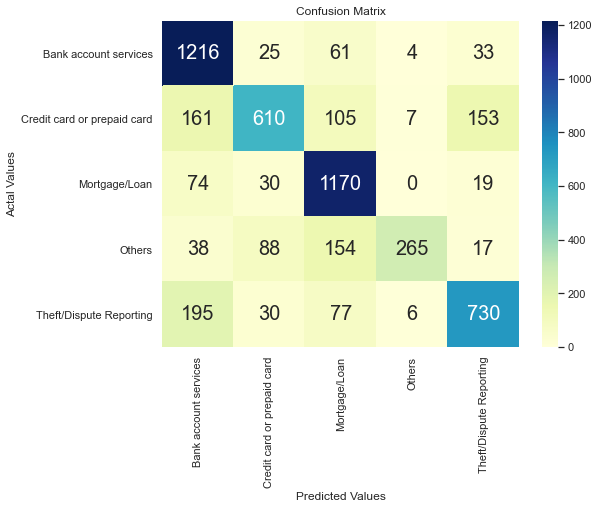

In [140]:
# Show confusion matrix
get_confusion_matrix(confusion)

In [141]:
# Function to get precision, recall, specificity and f1 score
def get_metrics(true_positives, true_negatives, false_positives, false_negatives) :
    precision = true_positives / float(true_positives + false_positives)
    recall = true_positives / float(true_positives + false_negatives)
    specificity = true_negatives / float(true_negatives + false_positives)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    return [precision, recall, specificity, f1_score]

In [142]:
# Function to get true_positives, false_positives, true_negatives and false_negatives for each topic
def get_metrics_for_topics(confusion) : 
    # Bank account services
    true_positives_bank_account = confusion[0,0]
    false_negatives_bank_account = confusion[0,1] + confusion[0,2] + confusion[0,3] + confusion[0,4]
    false_positives_bank_account = confusion[1,0] + confusion[2,0] + confusion[3,0] + confusion[4,0]
    true_negatives_bank_account = np.sum(confusion) - true_positives_bank_account - false_negatives_bank_account - false_positives_bank_account
    bas = get_metrics(true_positives_bank_account, true_negatives_bank_account, false_positives_bank_account, false_negatives_bank_account)
    # print(bas)

    # Credit card or prepaid card
    true_positives_credit_card = confusion[1,1]
    false_negatives_credit_card = confusion[1,0] + confusion[1,2] + confusion[1,3] + confusion[1,4]
    false_positives_credit_card = confusion[0,1] + confusion[2,1] + confusion[3,1] + confusion[4,1]
    true_negatives_credit_card = np.sum(confusion) - true_positives_credit_card - false_negatives_credit_card - false_positives_credit_card
    cc = get_metrics(true_positives_credit_card, true_negatives_credit_card, false_positives_credit_card, false_negatives_credit_card)
    # print(cc)

    # Mortgage/Loan
    true_positives_mortgage = confusion[2,2]
    false_negatives_mortgage = confusion[2,1] + confusion[2,0] + confusion[2,3] + confusion[2,4]
    false_positives_mortgage = confusion[1,2] + confusion[0,2] + confusion[3,2] + confusion[4,2]
    true_negatives_mortgage = np.sum(confusion) - true_positives_mortgage - false_negatives_mortgage - false_positives_mortgage
    ml =get_metrics(true_positives_mortgage, true_negatives_mortgage, false_positives_mortgage, false_negatives_mortgage)
    # print(ml)

    # Others
    true_positives_others = confusion[3,3]
    false_negatives_others = confusion[3,0] + confusion[3,2] + confusion[3,1] + confusion[3,4]
    false_positives_others = confusion[0,3] + confusion[2,3] + confusion[1,3] + confusion[4,3]
    true_negatives_others = np.sum(confusion) - true_positives_others - false_negatives_others - false_positives_others
    otr = get_metrics(true_positives_others, true_negatives_others, false_positives_others, false_negatives_others)
    # print(otr)

    # Theft/Dispute Reporting
    true_positives_theft = confusion[4,4]
    false_negatives_theft = confusion[4,1] + confusion[4,2] + confusion[4,3] + confusion[4,0]
    false_positives_theft = confusion[1,4] + confusion[2,4] + confusion[3,4] + confusion[0,4]
    true_negatives_theft = np.sum(confusion) - true_positives_theft - false_negatives_theft - false_positives_theft
    tdr = get_metrics(true_positives_theft, true_negatives_theft, false_positives_theft, false_negatives_theft)
    # print(tdr)
    
    return [bas, cc, ml, otr, tdr]


In [143]:
# Show precision, recall, specificity and f1 score for each topic
data = get_metrics_for_topics(confusion)
df_metrics = pd.DataFrame(data, columns = ['Precision', 'Recall', 'Specificity', 'F1 Score'], index = topic_list)
df_metrics

,Precision,Recall,Specificity,F1 Score
Bank account services,0.722090,0.908140,0.880886,0.804499
Credit card or prepaid card,0.779055,0.588803,0.959121,0.670698
Mortgage/Loan,0.746650,0.904872,0.900126,0.818182
Others,0.939716,0.471530,0.996388,0.627962
Theft/Dispute Reporting,0.766807,0.703276,0.947518,0.733668


In [144]:
# Function to show confusion matrix, accuracy, micro, macro and weighted precision, recall, f1 scores along with classification report
def get_overall_scores(y_test, predicted) :
    confusion = confusion_matrix(y_test, predicted)
    print('Confusion Matrix\n')
    print(confusion)

    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, predicted)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, predicted, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, predicted, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, predicted, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, predicted, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, predicted, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, predicted, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, predicted, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, predicted, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, predicted, average='weighted')))

    print('\nClassification Report\n')
    print(classification_report(y_test, predicted, target_names=topic_list))
    

In [145]:
# Show confusion matrix, accuracy, micro, macro and weighted precision, recall, f1 scores along with classification report
get_overall_scores(y_test, predicted_nb)

Confusion Matrix

[[1216   25   61    4   33]
 [ 161  610  105    7  153]
 [  74   30 1170    0   19]
 [  38   88  154  265   17]
 [ 195   30   77    6  730]]

Accuracy: 0.76

Micro Precision: 0.76
Micro Recall: 0.76
Micro F1-score: 0.76

Macro Precision: 0.79
Macro Recall: 0.72
Macro F1-score: 0.73

Weighted Precision: 0.77
Weighted Recall: 0.76
Weighted F1-score: 0.75

Classification Report

                             precision    recall  f1-score   support

      Bank account services       0.72      0.91      0.80      1339
Credit card or prepaid card       0.78      0.59      0.67      1036
              Mortgage/Loan       0.75      0.90      0.82      1293
                     Others       0.94      0.47      0.63       562
    Theft/Dispute Reporting       0.77      0.70      0.73      1038

                   accuracy                           0.76      5268
                  macro avg       0.79      0.72      0.73      5268
               weighted avg       0.77      0.76 

In [146]:
# Show precision, recall, specificity and f1 score for each topic
data = get_metrics_for_topics(confusion)
df_metrics = pd.DataFrame(data, columns = ['Precision', 'Recall', 'Specificity', 'F1 Score'], index = topic_list)
df_metrics

,Precision,Recall,Specificity,F1 Score
Bank account services,0.722090,0.908140,0.880886,0.804499
Credit card or prepaid card,0.779055,0.588803,0.959121,0.670698
Mortgage/Loan,0.746650,0.904872,0.900126,0.818182
Others,0.939716,0.471530,0.996388,0.627962
Theft/Dispute Reporting,0.766807,0.703276,0.947518,0.733668


## 9. Logistic Regression

In [147]:
# Build logistic regression model
lr_model = LogisticRegression(solver='liblinear')
lrm = lr_model.fit(X_train, y_train)

# Save model
pickle.dump(lrm, open("lr_model.pkl", "wb"))

In [148]:
# Predict the values of test set 
predicted_lr = lrm.predict(X_test)
result_log = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted_lr})

In [149]:
# Get the sample of predicted and actual labels
print(result_log.shape)
result_log

(5268, 2)


,true_labels,predicted_labels
10796,Mortgage/Loan,Mortgage/Loan
16441,Theft/Dispute Reporting,Theft/Dispute Reporting
16623,Mortgage/Loan,Mortgage/Loan
12833,Credit card or prepaid card,Credit card or prepaid card
14844,Theft/Dispute Reporting,Theft/Dispute Reporting
...,...,...
4745,Bank account services,Bank account services
12919,Others,Others
15234,Bank account services,Bank account services
11341,Bank account services,Bank account services


In [150]:
# Show the data of true labels against predicted labels
result_log[["true_labels", "predicted_labels",]].value_counts()

true_labels                  predicted_labels           
Bank account services        Bank account services          1292
Mortgage/Loan                Mortgage/Loan                  1265
Credit card or prepaid card  Credit card or prepaid card     968
Theft/Dispute Reporting      Theft/Dispute Reporting         965
Others                       Others                          514
Theft/Dispute Reporting      Bank account services            36
Credit card or prepaid card  Theft/Dispute Reporting          35
Theft/Dispute Reporting      Mortgage/Loan                    26
Bank account services        Theft/Dispute Reporting          18
Others                       Mortgage/Loan                    17
Bank account services        Mortgage/Loan                    17
Others                       Credit card or prepaid card      15
Credit card or prepaid card  Bank account services            15
Others                       Bank account services            13
Mortgage/Loan                Bank

In [151]:
# Show accuracy
accuracy = accuracy_score(y_test.values, predicted_lr)
accuracy

0.9498861047835991

In [152]:
# Show Confusion matrix
confusion_lr = confusion_matrix(y_test.values, predicted_lr)
print(confusion_lr)

[[1292   11   17    1   18]
 [  15  968    9    9   35]
 [  12    6 1265    1    9]
 [  13   15   17  514    3]
 [  36    9   26    2  965]]


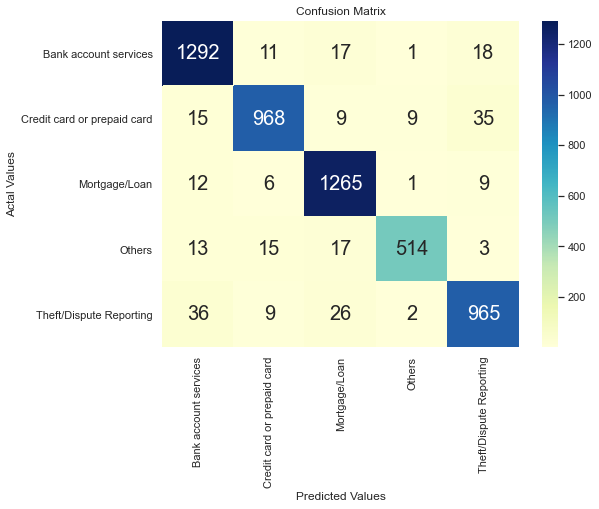

In [153]:
# Show confusion matrix with proper labels
get_confusion_matrix(confusion_lr)

In [154]:
# Show precision, recall, specificity and f1 score for each topic
data = get_metrics_for_topics(confusion_lr)
df_metrics = pd.DataFrame(data, columns = ['Precision', 'Recall', 'Specificity', 'F1 Score'], index = topic_list)
df_metrics

,Precision,Recall,Specificity,F1 Score
Bank account services,0.944444,0.964899,0.980657,0.954562
Credit card or prepaid card,0.959366,0.934363,0.990312,0.946699
Mortgage/Loan,0.948276,0.978345,0.982642,0.963076
Others,0.975332,0.914591,0.997238,0.943985
Theft/Dispute Reporting,0.936893,0.929672,0.984634,0.933269


In [155]:
# Show precision, recall, specificity and f1 score for each topic
get_overall_scores(y_test, predicted_lr)

Confusion Matrix

[[1292   11   17    1   18]
 [  15  968    9    9   35]
 [  12    6 1265    1    9]
 [  13   15   17  514    3]
 [  36    9   26    2  965]]

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.95
Macro Recall: 0.94
Macro F1-score: 0.95

Weighted Precision: 0.95
Weighted Recall: 0.95
Weighted F1-score: 0.95

Classification Report

                             precision    recall  f1-score   support

      Bank account services       0.94      0.96      0.95      1339
Credit card or prepaid card       0.96      0.93      0.95      1036
              Mortgage/Loan       0.95      0.98      0.96      1293
                     Others       0.98      0.91      0.94       562
    Theft/Dispute Reporting       0.94      0.93      0.93      1038

                   accuracy                           0.95      5268
                  macro avg       0.95      0.94      0.95      5268
               weighted avg       0.95      0.95 

## 10. Random Forest

In [156]:
rf = RandomForestClassifier(random_state=40, n_jobs=-1)

In [157]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

In [158]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [159]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   53.4s finished


CPU times: user 7.01 s, sys: 317 ms, total: 7.32 s
Wall time: 54.6 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=40),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [160]:
# Get the best score in hyper parameter tuned models
grid_search.best_score_

0.8026449000253101

In [161]:
# Get the model containing best score
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=40)

In [162]:
# Predict the values of test set 
predicted_rf = rf_best.predict(X_test)
result_rf = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted_rf})

In [163]:
# Get the sample of predicted and actual labels
print(result_rf.shape)
result_rf

(5268, 2)


,true_labels,predicted_labels
10796,Mortgage/Loan,Mortgage/Loan
16441,Theft/Dispute Reporting,Theft/Dispute Reporting
16623,Mortgage/Loan,Mortgage/Loan
12833,Credit card or prepaid card,Credit card or prepaid card
14844,Theft/Dispute Reporting,Theft/Dispute Reporting
...,...,...
4745,Bank account services,Bank account services
12919,Others,Others
15234,Bank account services,Bank account services
11341,Bank account services,Bank account services


In [164]:
# Show the data of true labels against predicted labels
result_rf[["true_labels", "predicted_labels",]].value_counts()

true_labels                  predicted_labels           
Bank account services        Bank account services          1246
Mortgage/Loan                Mortgage/Loan                  1186
Credit card or prepaid card  Credit card or prepaid card     765
Theft/Dispute Reporting      Theft/Dispute Reporting         708
Others                       Others                          289
Theft/Dispute Reporting      Bank account services           216
Credit card or prepaid card  Bank account services           117
Others                       Mortgage/Loan                   117
Credit card or prepaid card  Theft/Dispute Reporting         100
Others                       Credit card or prepaid card      95
Theft/Dispute Reporting      Mortgage/Loan                    66
Mortgage/Loan                Bank account services            54
Others                       Bank account services            53
Credit card or prepaid card  Mortgage/Loan                    49
Theft/Dispute Reporting      Cred

In [165]:
# Show accuracy
accuracy = accuracy_score(y_test.values, predicted_rf)
accuracy

0.7961275626423691

In [166]:
# Show Confusion matrix
confusion_rf = confusion_matrix(y_test.values, predicted_rf)
print(confusion_rf)

[[1246   31   42    1   19]
 [ 117  765   49    5  100]
 [  54   40 1186    0   13]
 [  53   95  117  289    8]
 [ 216   46   66    2  708]]


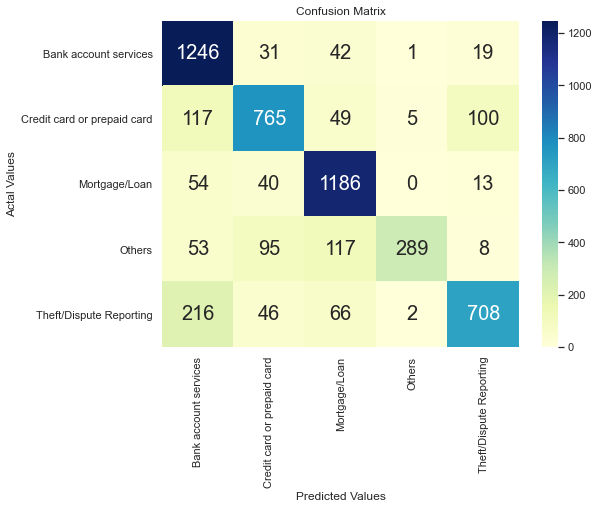

In [167]:
# Show confusion matrix with proper labels
get_confusion_matrix(confusion_rf)

In [168]:
# Show precision, recall, specificity and f1 score for each topic
data = get_metrics_for_topics(confusion_rf)
df_metrics = pd.DataFrame(data, columns = ['Precision', 'Recall', 'Specificity', 'F1 Score'], index = topic_list)
df_metrics

,Precision,Recall,Specificity,F1 Score
Bank account services,0.739027,0.930545,0.888012,0.823802
Credit card or prepaid card,0.783009,0.738417,0.949905,0.760060
Mortgage/Loan,0.812329,0.917247,0.931069,0.861606
Others,0.973064,0.514235,0.998300,0.672875
Theft/Dispute Reporting,0.834906,0.682081,0.966903,0.750795


In [169]:
# Show precision, recall, specificity and f1 score for each topic in Random forest
print("Random Forest :\n" )
get_overall_scores(y_test, predicted_rf)

Random Forest :

Confusion Matrix

[[1246   31   42    1   19]
 [ 117  765   49    5  100]
 [  54   40 1186    0   13]
 [  53   95  117  289    8]
 [ 216   46   66    2  708]]

Accuracy: 0.80

Micro Precision: 0.80
Micro Recall: 0.80
Micro F1-score: 0.80

Macro Precision: 0.83
Macro Recall: 0.76
Macro F1-score: 0.77

Weighted Precision: 0.81
Weighted Recall: 0.80
Weighted F1-score: 0.79

Classification Report

                             precision    recall  f1-score   support

      Bank account services       0.74      0.93      0.82      1339
Credit card or prepaid card       0.78      0.74      0.76      1036
              Mortgage/Loan       0.81      0.92      0.86      1293
                     Others       0.97      0.51      0.67       562
    Theft/Dispute Reporting       0.83      0.68      0.75      1038

                   accuracy                           0.80      5268
                  macro avg       0.83      0.76      0.77      5268
               weighted avg     

### Display overall scores for naive bayes and logistic regression

In [170]:
# Show precision, recall, specificity and f1 score for each topic in Naive bayes
print("Naive Bayes :\n" )
get_overall_scores(y_test, predicted_nb)

Naive Bayes :

Confusion Matrix

[[1216   25   61    4   33]
 [ 161  610  105    7  153]
 [  74   30 1170    0   19]
 [  38   88  154  265   17]
 [ 195   30   77    6  730]]

Accuracy: 0.76

Micro Precision: 0.76
Micro Recall: 0.76
Micro F1-score: 0.76

Macro Precision: 0.79
Macro Recall: 0.72
Macro F1-score: 0.73

Weighted Precision: 0.77
Weighted Recall: 0.76
Weighted F1-score: 0.75

Classification Report

                             precision    recall  f1-score   support

      Bank account services       0.72      0.91      0.80      1339
Credit card or prepaid card       0.78      0.59      0.67      1036
              Mortgage/Loan       0.75      0.90      0.82      1293
                     Others       0.94      0.47      0.63       562
    Theft/Dispute Reporting       0.77      0.70      0.73      1038

                   accuracy                           0.76      5268
                  macro avg       0.79      0.72      0.73      5268
               weighted avg       

In [171]:
# Show precision, recall, specificity and f1 score for each topic in Logistic Regression

print("Logistic Regression :\n" )
get_overall_scores(y_test, predicted_lr)

Logistic Regression :

Confusion Matrix

[[1292   11   17    1   18]
 [  15  968    9    9   35]
 [  12    6 1265    1    9]
 [  13   15   17  514    3]
 [  36    9   26    2  965]]

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.95
Macro Recall: 0.94
Macro F1-score: 0.95

Weighted Precision: 0.95
Weighted Recall: 0.95
Weighted F1-score: 0.95

Classification Report

                             precision    recall  f1-score   support

      Bank account services       0.94      0.96      0.95      1339
Credit card or prepaid card       0.96      0.93      0.95      1036
              Mortgage/Loan       0.95      0.98      0.96      1293
                     Others       0.98      0.91      0.94       562
    Theft/Dispute Reporting       0.94      0.93      0.93      1038

                   accuracy                           0.95      5268
                  macro avg       0.95      0.94      0.95      5268
               weighted av

## 11. Result

Looking at all results, I can conclude that Logistic Regression is best model for this problem as the values for ALL attributes are better for Logistic Regression when compared to Random Forest and Naive Bayes.

The attributes checked are :

* Accuracy 

* Micro Precision
* Micro Recall
* Micro F1-score

* Macro Precision
* Macro Recall
* Macro F1-score

* Weighted Precision
* Weighted Recall
* Weighted F1-score

* Bank account services Precision
* Bank account services Recall
* Bank account services F1-score

* Credit card or prepaid card Precision
* Credit card or prepaid card Recall
* Credit card or prepaid card F1-score

* Mortgage/Loan Precision
* Mortgage/Loan Recall
* Mortgage/Loan F1-score

* Others Precision
* Others Recall
* Others F1-score

* Theft/Dispute Reporting Precision
* Theft/Dispute Reporting Recall
* Theft/Dispute Reporting F1-score